## Notebook to work on Complex network >> Detection of Core-Periphery structure

### To do

#### Found community structure inside a given complex network
#### Identify global and local components for each community structure
#### Search core-periphery structure inside each identified component

- Use Zackary Karate club complex network
- Use complex network co-authorship scientists

#### Description of Zachary Karate club  network

Zachary Karate club is a social network of friendships between **34 members of a karate club at a US university in 1970s**.

In [1]:
# importation of modules
import cpnet
import math
import pandas as pd
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from networkx.algorithms import community
import pyvis
from pyvis import network as net

In [2]:
def drawer(net: pyvis.network, graph: nx.Graph(),  fixed: bool, partition=None):
    if( partition != None):
        for node in graph.nodes:
            graph.nodes[node]['group'] = partition[node]
            graph.nodes[node]['label'] = str(partition[node])
    nt = net.Network('500px', '500px')
    grid = net.Network(notebook=True)
    grid.from_nx(graph)
    grid.toggle_physics(fixed)
    return grid.show("test.html")

In [3]:
# Graph definition
kc_graph = nx.karate_club_graph()
#nx.draw_networkx(kc_graph, node_size=300)

In [4]:
# Communities detection with Louvain algorithm

partition = community_louvain.best_partition(kc_graph, resolution=1.0, randomize=True)

In [5]:
drawer(net, kc_graph, True, partition)

test.html


## Component Structure of complex network
### Definition: 
A component structure define a network with two sets of subnetworks:
- vthe dense parts of the network form the **local components**
- Nodes and links shared by any two local components form the **global components**

### Component Structure detection algorithm
The algorithm to uncover the component structure of a network proceeds as follows:
1. Uncover the dense part of the network: Use a community detection algorithm to uncover the community
2. Extract the **local components**: Remove the inter-community links from community structure to form the local components
3. Extract the **global component**: Remove the intra-community links from community structure and the subsequent **isolated nodes**

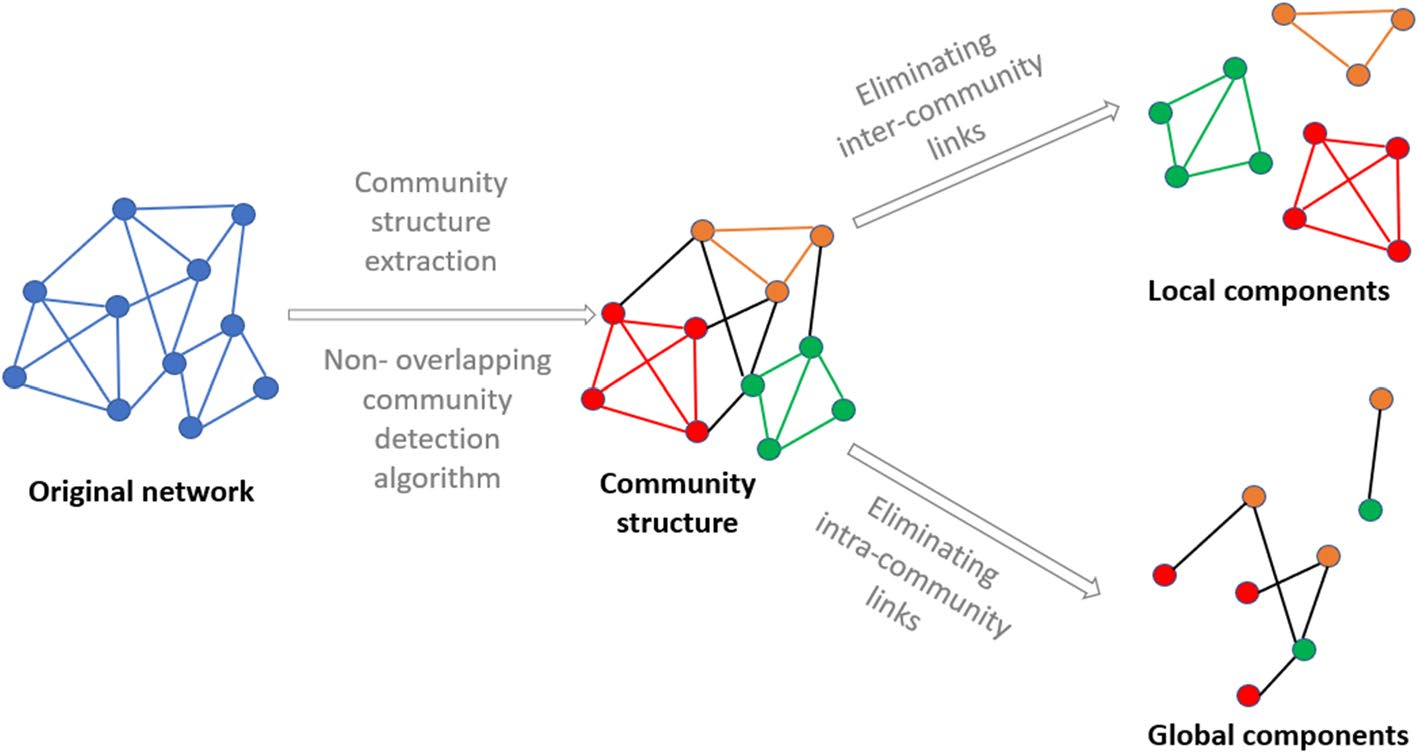

[2021]: Diop et al (Revealing the components structure of the world air transportation network)

In [6]:
class ComponentStructure:
    
    def __init__(self, graph, partition: dict):
        self.graph = nx.Graph.copy(graph)
        self.partition = partition
        self.communities_id = self.__get_communities()
        self.local_components = []
        self.global_components = []
        
    def set_local_components(self):
        for community_id in self.communities_id:
            nodes = set([k for k, v in self.partition.items() if v == community_id])
            part = {k: v for k, v in self.partition.items() if v == community_id}
            local_component = {"lc": self.graph.subgraph(nodes), "partition": part}
            self.local_components.append(local_component) 
        return partition
    
    def remove_intra_community_edges(self):
        temp_graph = nx.Graph.copy(self.graph)
        for community_id in self.communities_id:
            nodes = set([k for k, v in self.partition.items() if v == community_id])
            for node in nodes:
                neighbors = set(nx.neighbors(temp_graph, node))
                inner_nodes = neighbors.intersection(nodes)
                for inner_node in inner_nodes:
                    temp_graph.remove_edge(node, inner_node)
        temp_graph.remove_nodes_from(list(nx.isolates(temp_graph)))
        part = {k: v for k, v in self.partition.items() if k in temp_graph.nodes()}
        return {'gp':temp_graph, 'part':part}
    
    def __get_communities(self) -> set:
        return set(self.partition.values())
    
"""Cette fonction permet de grossir la taille d'un noeud en fonction du nombre de communautés auxquelles est connectée"""
def important_of_node(graph, node):
    groupes = []
    list_of_neighbors = list(nx.neighbors(graph, node))
    graph_data = dict(graph.nodes.data())
    neighbors_data = {k:v for k, v in graph_data.items() if k in list_of_neighbors}
    
    for k in neighbors_data.keys():
        groupes.append(neighbors_data[k]['group'])
    communities_groupes = list(set(groupes))
    #same_communities_neighbors = {k:v for k, v in neighbors_data.items() if v['group'] == communities_groupes[0]}
    number_of_nodes = len(communities_groupes)
    
    graph.nodes[node]['size'] = 10*number_of_nodes
    return 

In [7]:
A = ComponentStructure(kc_graph, partition)
A.set_local_components()
global_component = A.remove_intra_community_edges()

In [10]:
drawer(net, global_component['gp'], True, global_component['part'])

test.html


### Global components for the network

### Uncovering core-periphery insides global and local components of the network

In [11]:
gc = global_component['gp']
main_partition = global_component["part"]

In [12]:
graphs = list(nx.connected_components(gc))

In [13]:
gc1 = gc.subgraph(graphs[0])
part = {k:v for k,v in main_partition.items() if k in gc1.nodes()}

In [14]:
drawer(net, gc1, True, part)

test.html


### Main global component

In [15]:
algo = cpnet.BE()
algo.detect(gc1)
x = algo.get_coreness()  # Get the coreness of nodes
c = algo.get_pair_id()

/home/devtool/anaconda3/lib/python3.10/site-packages/cpnet/utils.py:20: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  sparse.csr_matrix(nx.adjacency_matrix(net), dtype=np.float64),


In [16]:
for k in x:
    x[k] = int(x[k])
drawer(net, gc1, True, x)

test.html


In [17]:
#### Vendre la structure en composante de manière théorique
#### Faire des illustrations aussi
#### Rechercher des composantes locales et globales à partir de structures core-periphériques

### Use network scientists Co-authorship dataset to:
> - Get global and local components
> - Uncover Core-periphery structure from global components

### Load dataset and build the network

In [18]:
fil_name = 'edge_list.xlsx'
dataset = pd.ExcelFile(fil_name)
sheets = dataset.sheet_names
sheets

['Sheet1']

In [19]:
# We have a signle sheet in the dataset so Data are stored in that sheet
data = dataset.parse(sheet_name=sheets[0])

In [18]:
data.head()

edge_size      source_node      target_node
0          2  Franchi, Enrico  Franchi, Enrico
1          1      Mili, Fatma    Mohan, Srikar
2          1      Mili, Fatma     Qu, Guangzhi
3          1    Mohan, Srikar     Qu, Guangzhi
4          4       Gao, Liang      Gao, Zi-You

### Data description:
> Data si a collection of network scientists co-authorship informations of scientific paper.
> We have three columns:
- **edge_size** represent the number of co-authorship papers from two set of scientific
- **source_node** represent the source node of co-authorship relations
- **target_node** represent the target node of coèauthorship relations

In [20]:
G = nx.from_pandas_edgelist(data, source='source_node', target='target_node', create_using=nx.Graph())

In [21]:
print(len(G.edges()))
print(len(G.nodes()))

359584
56646


In [22]:
selfloop_edges = list(nx.selfloop_edges(G))
print("We have  "+str(len(selfloop_edges))+ " selfloops in the graph")

We have  1999 selfloops in the graph


In [23]:
G.remove_edges_from(selfloop_edges)

In [24]:
selfloop_edges = list(nx.selfloop_edges(G))
print("We have  "+str(len(selfloop_edges))+ " selfloops in the graph")

We have  0 selfloops in the graph


In [25]:
isolates_nodes = list(nx.isolates(G))
print("We have  "+str(len(isolates_nodes))+ " isolates nodes in the graph")

We have  897 isolates nodes in the graph


In [26]:
G.remove_nodes_from(isolates_nodes)

In [27]:
isolates_nodes = list(nx.isolates(G))
print("We have  "+str(len(isolates_nodes))+ " isolates nodes in the graph")

We have  0 isolates nodes in the graph


In [28]:
#Show edges
len(G.edges())

357585

### Uncover Global and local components Steps:
- Uncover Communities
- Apply Component structure algorithm
- Get Global and Local Component
- Get all connected global components in a list of graph
- Apply core-periphery detection algorithm to global component

In [29]:
# Communities detection with Louvain algorithm
partition_dict = community_louvain.best_partition(G, resolution=1.0, randomize=True)

In [30]:
number_of_communities = len(set(partition_dict.values()))
print("Number of communities is: "+ str(number_of_communities))

Number of communities is: 4968


In [31]:
GLC = ComponentStructure(G, partition_dict)
GLC.set_local_components()
global_component = GLC.remove_intra_community_edges()

In [34]:
print("we have "+str(len(GLC.local_components))+" local components")

we have 4968 local components


In [35]:
lc = GLC.local_components[1]
lc_graph = lc['lc']
partition = lc['partition']

In [36]:
drawer(net, lc_graph, True)

test.html


In [37]:
gc = global_component['gp']
gc_partition = global_component['part']
graphs = list(nx.connected_components(gc))

In [38]:
drawer(net, gc, True, gc_partition)

test.html


In [41]:
gc1 = gc.subgraph(graphs[0])
gc1_partition = {k:v for k,v in gc_partition.items() if k in gc1.nodes()}
drawer(net, gc1, True, gc_partition)

test.html


In [42]:
nx.write_gml(gc1, "main_global_component.gml")

### Uncover core-periphery in the main component of global component of the network scientist

In [44]:
algo = cpnet.BE()
algo.detect(gc1)
x = algo.get_coreness()  # Get the coreness of nodes
c = algo.get_pair_id()

In [45]:
for k in x:
    x[k] = int(x[k])

In [46]:
drawer(net, gc1, True, x)

test.html


On voit bien que les noeud ayant plus de connections avec d'autres communauts sont pour l'essentiel dans le core